In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("/content/time_data.csv")
data.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


Create index based on month

In [3]:
data.index = pd.to_datetime(data['Month'])
data.drop(columns='Month',inplace=True)
data.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


Preprocess data

In [4]:
data.isna().sum()

Sales    0
dtype: int64

In [6]:
data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


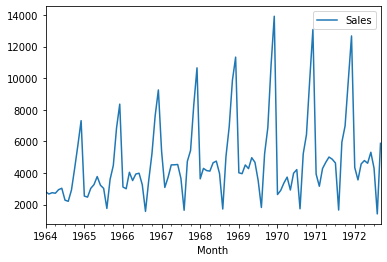

In [7]:
data.plot()

Decompose time series

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


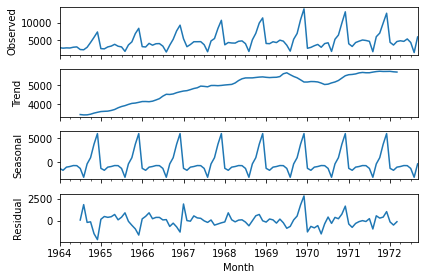

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data, model="additive")
decompose_data.plot();

Visualize the seasons

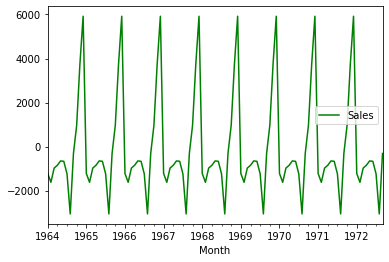

In [9]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

Performing the adfuller test 

In [10]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data.Sales, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.8335930563276228
2. P-Value :  0.363915771660245
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 93
5. Critical Values :
	 1% :  -3.502704609582561
	 5% :  -2.8931578098779522
	 10% :  -2.583636712914788


The p-value is higher than p-0.05. Therefore, we reject the hypothesis that the time series is stationary at a 95% confidence level. Hence the time series is non-stationary. We can make the time series stationary with differencing methods. In this case, we are going ahead with the rolling mean differencing methods. 

When there is a strong seasonal effect, we use the rolling mean differencing.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


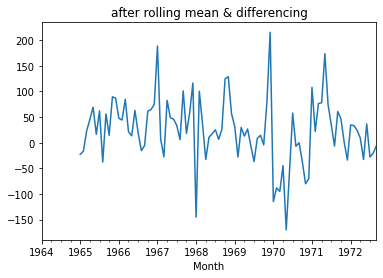

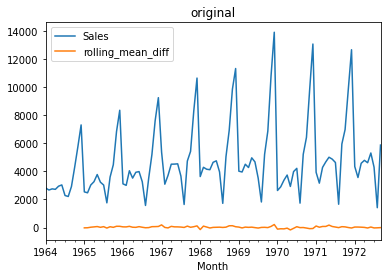

In [11]:
rolling_mean = data.rolling(window = 12).mean()
data['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
data.plot(title='original');

In [12]:
dftest = adfuller(data['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -7.626619157213174
2. P-Value :  2.0605796968135582e-11
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 92
5. Critical Values :
	 1% :  -3.503514579651927
	 5% :  -2.893507960466837
	 10% :  -2.583823615311909


We can see that the p-value is near about zero and very less than 0.05; now, our time series is stationary.  Rule of thumb: low p-value (p-value < alpha) implies stationarity.

ARIMA model

In [13]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(data['Sales'],order=(1,1,1))
history=model.fit()
history.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Mon, 13 Sep 2021   AIC                           1910.251
Time:                        11:00:23   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7848     12.405      1.837      0.069      -1.529      47.099
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Forecasting with ARIMA

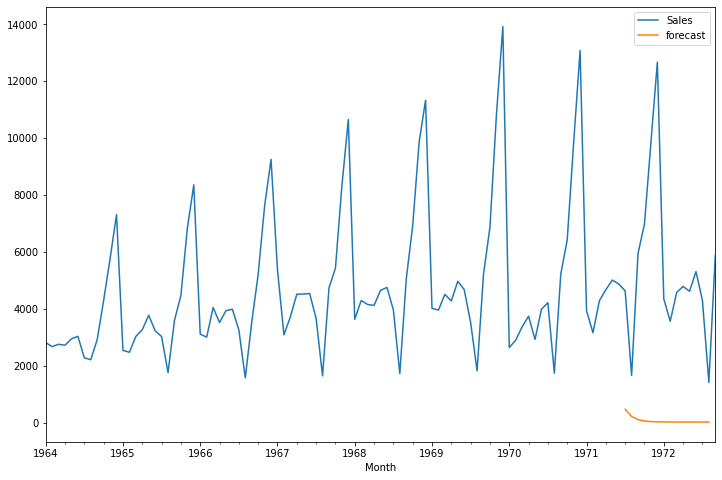

In [15]:
data['forecast']=history.predict(start=90,end=103,dynamic=True)
data[['Sales','forecast']].plot(figsize=(12,8))

We apply the model with the data after differencing the time series.

In [16]:
model=ARIMA(data['rolling_mean_diff'].dropna(),order=(1,1,1))
model_fit=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


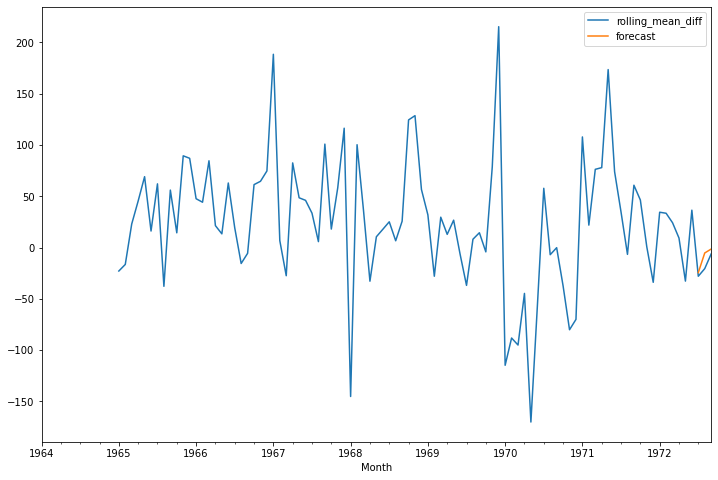

In [17]:
data['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
data[['rolling_mean_diff','forecast']].plot(figsize=(12,8))

SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model. ARIMA includes an autoregressive integrated moving average, while SARIMAX includes seasonal effects and eXogenous factors with the autoregressive and moving average component in the model. Therefore, we can say SARIMAX is a seasonal equivalent model like SARIMA and Auto ARIMA.

In [18]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


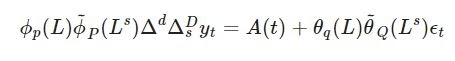

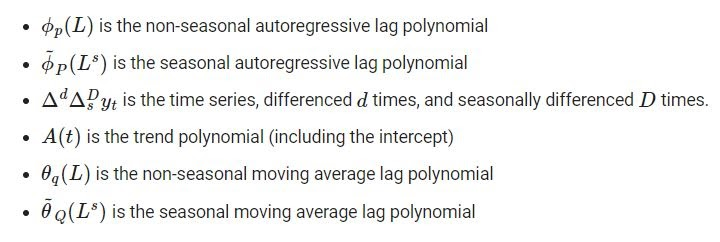

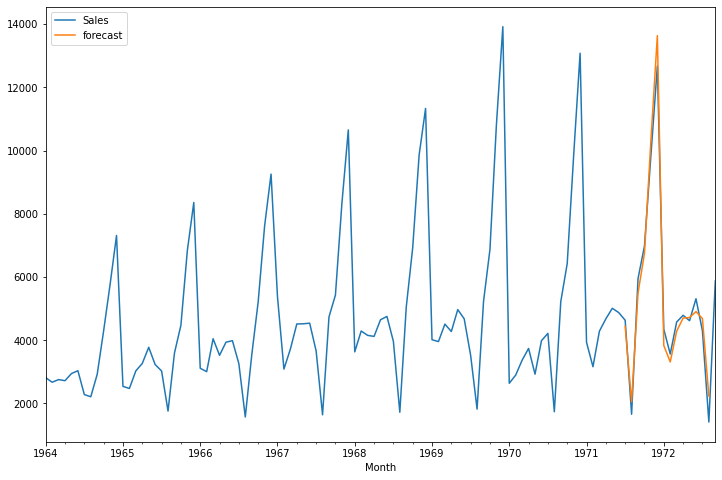

In [19]:
data['forecast']=results.predict(start=90,end=103,dynamic=True)
data[['Sales','forecast']].plot(figsize=(12,8))

Making a NAN value future dataset.

In [20]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [21]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,Sales,rolling_mean_diff,forecast
1972-10-01,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN


To make forecasted values, we need to concate this blank data with our alcohol sales data.

In [22]:
data=pd.concat([data,pred_date])

Making the prediction.

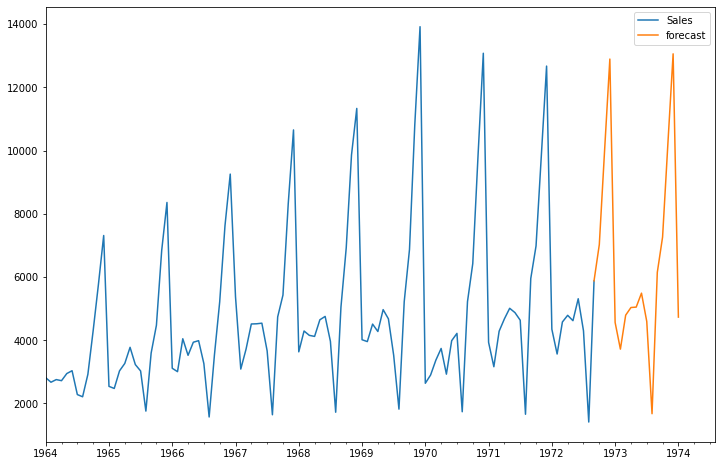

In [23]:
data['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
data[['Sales', 'forecast']].plot(figsize=(12, 8))